**Let's Figure Out how we can embed the text and floating point parameters**

Embedding is the method in which a continue value or a discrete variable can be represented in a continuous vector. Embedding is a highly utilized method in machine translation and entity embedding for categorical variables. 

An embedding is a mapping of a discrete — categorical — variable to a vector of continuous numbers. In the context of neural networks, embeddings are low-dimensional, learned continuous vector representations of discrete variables.

The primary reasons for embedding content is to the nearest neighbors within a given embedding space, as an input for a supervised task, or visualization of categories. 

In a nutshell, NN embeddings can easily take all 37,000 book articles on Wikipedia and represent each one using only 50 numbers in a vector.

**Creating the Token Embedder**

Then what I had in mind was:
<CLS> ==> [tokenizer embedding module] ==> embedding in R^d


In [356]:
import numpy as np
import pandas as pd
import math
import random
import json



token_0 = "[CLS]"
numberOfExamples = 6400
shapes = ["Sphere", "Cylinder", "Cubic"]

#sentence = "[CLS] Shape { 23.2,13,14.2 }"

def createSentece(numberOfExamples):
    shapeList = []

    for i in range(numberOfExamples):
        shape = random.choice(shapes)
        
        sentence = ""

        if shape == "Sphere":
            radius = np.random.uniform(1, 5).__round__(2)
            sentence = "[CLS] " + shape + " { " + str(radius) + " }"
        elif shape == "Cylinder":
            radius = np.random.uniform(1, 5).__round__(2)
            height = np.random.uniform(1, 5).__round__(2)
            sentence =  "[CLS] " + shape + " { " + str(radius) + ", " + str(height) + " }" 
        elif shape == "Cubic":
            length = np.random.uniform(1, 5).__round__(2)
            height = np.random.uniform(1, 5).__round__(2)
            width = np.random.uniform(1, 5).__round__(2)
            sentence =  "[CLS] " + shape + " { " + str(length) + ", " + str(height) + ", " + str(width) + " }"
        else:
            print("Error")

        shapeList.append(sentence)
        #print(sentence)
    return shapeList

generatedShape = createSentece(numberOfExamples)
#print(generatedShape)

with open("sentences.json", 'w') as f:
    json.dump(generatedShape, f, indent=2) 

with open("sentences.json", 'r') as f:
    s = json.load(f)

print(s[:10])
print(len(s))


['[CLS] Cubic { 2.61, 4.69, 1.49 }', '[CLS] Cubic { 2.47, 4.2, 1.11 }', '[CLS] Cylinder { 3.8, 1.21 }', '[CLS] Sphere { 1.54 }', '[CLS] Sphere { 2.4 }', '[CLS] Cylinder { 3.36, 2.12 }', '[CLS] Cylinder { 1.5, 3.22 }', '[CLS] Sphere { 2.81 }', '[CLS] Sphere { 4.64 }', '[CLS] Sphere { 3.59 }']
6400


**Importing all Relevent Images and Data**

This section is dedicated to importing all the images, of the dataset created in the json file above. 

There are 0 directories and 64 images in '/Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/NLP_NERF_CAD/renders'.
Random image path: /Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/NLP_NERF_CAD/renders/3_300.png
Image class: renders
Image height: 500
Image width: 500


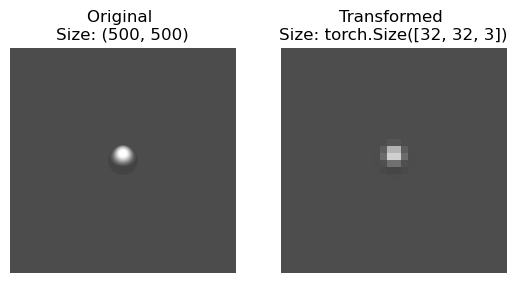

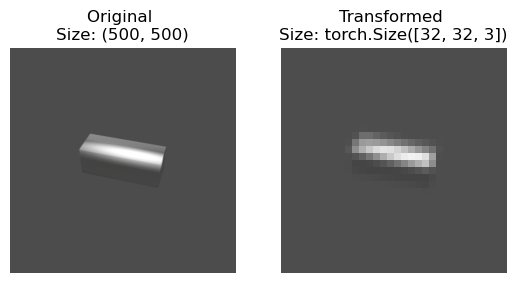

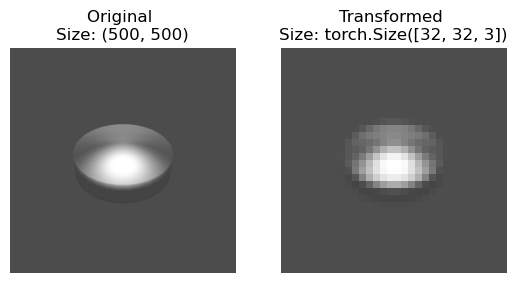

In [266]:
import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
#image_path = Path("/Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/NLP_NERF_CAD/renders")

image_path = Path("/Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/NLP_NERF_CAD")
train_dir = image_path / "renders"

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
walk_through_dir(train_dir)

import random
from PIL import Image
from pathlib import Path

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(train_dir.glob("*.png"))
train_image_list, valid_image_list = image_path_list[:int(0.8*len(image_path_list))], image_path_list[int(0.8*len(image_path_list)):] 



# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(32, 32)),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])


def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            

plot_transformed_images(train_image_list, 
                        transform=data_transform, 
                        n=3)

**Loading the Images using the dataloader**

In [357]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
image_path = Path("/Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/")
train_dir = image_path / "NLP_NERF_CAD"



print(train_dir)
# Batch size will now be 32, try changing the batch_size parameter above and see what happens
totalImgs = numberOfExamples

img_data = datasets.ImageFolder(root=image_path, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)


img_dataloader = DataLoader(dataset=img_data, 
                              batch_size=numberOfExamples, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=False) # shuffle the data?

img = next(iter(img_dataloader))[0].numpy()
# I need to get total img dataset size

/Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/NLP_NERF_CAD


In [358]:
#img[0].shape
#img_data.shape
img = next(iter(img_dataloader))[0]
img.shape

torch.Size([6400, 3, 32, 32])

**Creating a Tokenizer and LxD Matrix for Transformers**

Tokenization — this preprocessing step means transforming unstructured Natural Language input in something better structured (in computer terms). The main idea is to break the textual input into fragments that contain granular, yet useful data — these are called Tokens. 

Following the tokenization process and the MLP encoding into (1,10) vectors. We have to create a LxD matrix to pass into the nn.transformer.


In [276]:
import torch 
import torch.nn as nn
from torch.nn import Embedding
import numpy as np
from torch.utils.data import TensorDataset, DataLoader


dictionary = """[SEP] [CLS] Cylinder Sphere Cubic [SEP] { } ,"""
sentence = "[CLS] Cubic { 23.2,13,14.2 }"
tokens = dictionary.split()
d = 10


def processText(text):
  text = text.replace('{', '{ ')
  text = text.replace('}', '} ')
  updatedText = text.replace(',', ' ').split(' ')
  updatedText = ' '.join(updatedText).split()
  return updatedText

class token:
  def __init__(self, tokens):
    self.tokens = tokens.split()
    self.embedding = nn.Embedding(50, d) 
    
  def encode(self, sentence):

    split = processText(sentence)
    encoded = []
    
    for word in split:
      if word in self.tokens:
        encoded.append(self.tokens.index(word))
      else:
        encoded.append(word)

    return encoded

  def decode(self, encoded):
    decoded = []
    #print(encoded)
    for i in encoded:
      
      if type(i) == str:
        decoded.append(float(i))
      else:
        decoded.append(self.tokens[i])
    return decoded


  def tensorEncoded(self, encoded):
    newList = []
    tensorList = []
    for i in encoded:
      newList.append(float(i))

    for i in newList:
      tensorList.append(torch.tensor([i]))

    return tensorList
  
  def npEncode(self, sentence):
    newList = []
    maskList = []
    encoded = self.encode(sentence)

    for i in encoded:

      newList.append(float(i))
      if (encoded.index(i) < 3) or (encoded.index(i) == len(encoded) - 1):
        maskList.append(1)
      else:
        maskList.append(0)

    
    if len(newList) < 7:
      for i in range(7-len(newList)):
        newList.append(0.0)
        maskList.append(0)

    return newList, maskList

  def tensorList(self, encoded):
    array = []
    for i in encoded:
      array.append(np.array(i)[0])

    return(array)

def createDataSet(text):
  dataSet = []
  for i in text:
    dataSet.append(tokens.encodeD(i))
  dataSet = torch.stack(dataSet)
  return dataSet

def createData(text):
  dataSet = []
  masks = []
  for i in text:
    dataSet.append(tokens.npEncode(i)[0])
    masks.append(tokens.npEncode(i)[1])
  
  return np.array(dataSet), np.array(masks)



tokens = token(dictionary)
encoded = tokens.encode(sentence)
decoded = tokens.decode(encoded)
tokens = token(dictionary)






x = tokens.npEncode(sentence)
print(x)





([1.0, 4.0, 6.0, 23.2, 13.0, 14.2, 7.0], [1, 1, 1, 0, 0, 0, 1])


**Creating a Custom Embedding, Transformer, and Classifier Module**

In [542]:
import math
from typing import Tuple
bttp = 16
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset



class customEmbedding(nn.Module):
    def __init__(self, len_vocab=10, embedding_dimension=128):
        super().__init__()
        self.embedding = nn.Embedding(len_vocab, embedding_dimension)
        self.linear = nn.Linear(1, embedding_dimension)

    def forward(self, tokens, discrete_mask):
        """
        Args:
            Embed the tokens through a 1 layer MLP, and through the nn.Embedding layer
            tokens: (batch_size, seq_len)
            discrete_mask: (batch_size, seq_len)
        Output:
            embeddings: (batch_size, seq_len, d)
        """

        tokens = tokens.to(torch.float32)
        discrete_mask = discrete_mask.to(torch.float32)

        # Mask the tokens to remove float values that may be larger than the number of embeddings
        token_mask = torch.mul(tokens.to(torch.int64), discrete_mask.to(torch.int64))
        embeddings = self.embedding(token_mask)

        # Use the size of the tokens to get the batch size dim
        batch_size = tokens.size(0)

        # Embed the Sentence as if it were a continuous value
        token_reshaped = tokens.view(batch_size, 7, 1) # (batch_size, seq_len, 1) basically update the shape of the tensor
        linear_embeddings = self.linear(token_reshaped)

        # Create the continuous mask, and expand it to match the embedding dimension
        discrete_mask = discrete_mask.unsqueeze(-1)
        discrete_mask = discrete_mask.expand_as(embeddings)
        discrete_mask_inv = 1 - discrete_mask

        embeded = embeddings * discrete_mask + linear_embeddings * discrete_mask_inv
        return embeded
        
# custom convolutional neural network to embed the 32x32 images into a 1 x 10d vector
class customCNN(nn.Module):
    def __init__(self, embedding_dim: int):

        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(16 * 5 * 5, embedding_dim*2),
            nn.ReLU(),
            nn.Linear(embedding_dim*2, embedding_dim),
            
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.embeder = customEmbedding(len_vocab=10, embedding_dimension=128)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model

    
    def encoder(self, src: Tensor, msk_list: Tensor, src_mask: Tensor) -> Tensor:

        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output is encoded tensor 
        """

        src =  self.embeder(src, msk_list) * math.sqrt(self.d_model) #self.encoder(src) *
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        #print(output[0])
        return output


    def forward(self, src: Tensor, msk_list: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        
        output = self.encoder(src, msk_list, src_mask)
        
        
        return output


# Create a Custom MLP that takes in the output of the CNN and outputs a 1 x 10d vector, and use a cross entropy loss to determine if it can correctly choose the correct class
class customMLP(nn.Module):
    def __init__(self, ntoken=10, d_model=128, nhead=8, d_hid=128, nlayers=6, dropout=0.5): # add in all the parameters that you want to pass in
        super().__init__()
        

        # Pass the sentence through the embedder which goes through the custom transformer layer
        self.token_encoder = TransformerModel(ntoken=10, d_model=128, nhead=8, d_hid=128, nlayers=6, dropout=0.5) #TransformerModel(src, src_mask)
        # Encode the images using the customCNN
        self.cnn_encoder = customCNN(embedding_dim=d_model) #customCNN(images)
        # Concatenate the two vectors together, the first vector is the sentence, the second vector is the image. the sentence has the dimensions of
        # BatchSize x LenghtOfSentence x EmbeddingDimension, and the image has the dimensions of BatchSize x 1 x EmbeddingDimension
        self.concat = nn.Linear(2*d_model, d_model)

        # Pass the concatenated vector through a softmax layer to get the final output
        # Linear and Softmax layer for the final output
        self.sigmoid = nn.Sigmoid() 
        self.fc = nn.Linear(d_model, round(d_model/2))
        self.fc2 = nn.Linear(round(d_model/2), 1)
    

    def forward(self, src, msk_list, src_mask, images):
        # Pass the sentence through the embedder which goes through the custom transformer layer
        token_output = self.token_encoder(src, msk_list, src_mask)   # (b, L, d)
        # Encode the images using the customCNN
        image_output = self.cnn_encoder(images)

        token_output= token_output[:, 0 , :] # (b, d)
        # Concatenate the two vectors together
        concat_output = self.concat(torch.cat((token_output, image_output), 1)) # (b, 2d) -> (b, d)
        # Pass the concatenated vector through a softmax layer to get the final output
        output = self.fc(concat_output) # (b, embedding_dim)
        output = self.fc2(output) # (b, 1)
        # maybe add a second hidden laer
        #output = self.sigmoid(output)
        #score = self.fc(output) # `score` is the output of the MLP (b, 1)

        return output
        


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


In [253]:
sentence_set = createSentece(64)
data, masks  = createData(s)

tensor_data = torch.tensor(data)
tensor_masks = torch.tensor(masks)

dataset = TensorDataset(tensor_data, tensor_masks)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

d = dataset[0:2][0]
m = dataset[0:2][1]
model = customEmbedding()
output = model(d, m)
output.shape
print(d,m)


tensor([[1.0000, 4.0000, 6.0000, 3.4400, 2.4400, 2.4700, 7.0000],
        [1.0000, 2.0000, 6.0000, 2.0800, 1.6200, 7.0000, 0.0000]],
       dtype=torch.float64) tensor([[1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0, 1, 0]])


In [178]:
encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8)
bsize = 2
src = torch.rand(10, 32, 512)
out = encoder_layer(output)
out.shape

msk = generate_square_subsequent_mask(2)
tm = TransformerModel(ntoken=10, d_model=128, nhead=8, d_hid=128, nlayers=6, dropout=0.5)
model = customCNN(embedding_dim=128)

print(tm(d, m, msk).shape)

torch.Size([2, 7, 128])


In [228]:
import torch.optim as optim
mlp_model = customMLP(ntoken=10, d_model=128, nhead=8, d_hid=128, nlayers=6, dropout=0.5)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.001, momentum=0.9)
out2 = mlp_model(d, m, msk, img[0][:2])
out2.shape
print(out2)

# convert to torch to float
#img = torch.tensor(img).float()
output = torch.cat((out2, out2), 1).float()
gt = torch.tensor([[1], [0]]).float()


trn = gt.expand(output.shape) # ground truth tensor of 1, 0 expanded to fit the concatenated output for the given batch size
print(output)
print(trn)
loss = nn.BCELoss()
output = loss(output, trn)
output


load_eval_batches = DataLoader(data_complete, batch_size=32, shuffle=False)

setset = img[0]
setset[0,1].shape

tensor([[0.4197],
        [0.4328]], grad_fn=<SigmoidBackward0>)
tensor([[0.4197, 0.4197],
        [0.4328, 0.4328]], grad_fn=<CatBackward0>)
tensor([[1., 1.],
        [0., 0.]])


torch.Size([32, 32])

Load Batches

In [543]:
data, masks  = createData(s)
tensor_data = torch.tensor(data)
tensor_masks = torch.tensor(masks)


# Basically every batch can be divided like this...
print(tensor_data.shape)
print(tensor_masks.shape)
print(img.shape)


data_complete = TensorDataset(tensor_data, tensor_masks, img) # torch.Size([b, 7]), torch.Size([b, 7]), torch.Size([b, 3, 32, 32])
load_batches = DataLoader(data_complete, batch_size=16, shuffle=False)
train_data = next(iter(load_batches))

sentenceD = train_data[0] # (b, L)
sentenceMskD = train_data[1] # (b, L)
imgD = train_data[2] # (b, 3, 32, 32)

sentenceD.shape
len(load_batches)

torch.Size([6400, 7])
torch.Size([6400, 7])
torch.Size([6400, 3, 32, 32])


400

In [179]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
output

tensor(1.0738, grad_fn=<BinaryCrossEntropyBackward0>)

**Positional Encoding**

**Create the Training for the CNN and Transformer Similarity**

Unlike a typical transformer, we ourselves, encode the tokens of the sentence, allowing us to encode both words and floating points.

In [549]:
import time

mlp = customMLP(ntoken=10, d_model=128, nhead=8, d_hid=128, nlayers=6, dropout=0.5)
lr=0.00001 # learning rate
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=lr,  momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.8)
bptt = 16 # batch size for training of 32
transformer_msk = generate_square_subsequent_mask(bptt)

def train(model: nn.Module) -> None:
      #model.train()  # turn on train mode
      total_loss = 0.
      num_batches = len(load_batches)
      optimizer.zero_grad() # zero out the gradients

      for i, batch in enumerate(load_batches):

            # Get the model's output for the tensor with the correct image and an incorrect image
            # (batch_size x 2) Concatenated output of the two images, to compare to the ground truth Should be a 2d tensor 1,0 at convg.
            # input (l, I_v) -> scalar output [x] -> batch_size x 1
            
            src = batch[0] # (b, L)
            msk = batch[1] # (b, L)
            img_c = batch[2] # (b, 3, 32, 32)
            img_f = img_c[(randomShuffle(bptt))] # shuffle the images to get a false image

            output_ic = model(src, msk, transformer_msk, img_c).float() # (b, 1)
            output_if = model(src, msk, transformer_msk, img_f).float() # (b, 1)
            output = torch.cat((output_ic, output_if), 1) # (2 x b) 

            # Put output_ground and false into one tensor continaing the other two tensors
            # Tensor of labels to the corect size. Batch_size x 2 Ex when bttp=2: [[1, 1], [0, 0]]
            target_1, target_0 = torch.tensor([[1]]).float(), torch.tensor([[0]]).float()
            target_1 = target_1.expand(output_ic.shape)  # (2 x b)
            target_0 = target_0.expand(output_if.shape)  # (2 x b)
            target = torch.cat((target_1, target_0), 1) # (2 x b)
            
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

            total_loss += loss.item()
            if i % bptt == 0 and i > 0:
                lr = scheduler.get_last_lr()[0]
                print(f'| epoch {epoch:3d} | {int(i):3d} / {num_batches:3d} batches | '
                        f'lr {lr:00002.10f} | '
                        f'loss {total_loss:5.2f} |')
                total_loss = 0

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt)
    with torch.no_grad():
        for i, batch in enumerate(load_eval_batches):
            
            src = batch[0] # (b, L)
            msk = batch[1] # (b, L)
            img_c = batch[2] # (b, 3, 32, 32)
            img_f = img_c[torch.tensor(randomShuffle(bptt))] # shuffle the images to get a false image

            output_ic = model(src, msk, transformer_msk, img_c).float() # (b, 1)
            output_if = model(src, msk, transformer_msk, img_f).float() # (b, 1)
            data = torch.cat((output_ic, output_if), 1) # (2 x b) 
            
            target = torch.tensor([[1], [0]]).float()
            target = target.expand(output.shape)  # (2 x b)
            
            # Calculate the loss using BCE loss, optimizer step 
            total_loss += criterion(data, target)

    return total_loss / (len(eval_data) - 1)

# Shuffle Image Data for false image match to the correct text, returns a list of the shuffled indexes unlike the original
# tensor=tensor[torch.tensor(randomShuffle(bttp))] 

def randomShuffle(batchSize):
    original = np.arange(batchSize)
    shuffled = np.arange(batchSize)
    np.random.shuffle(shuffled)

    dif = np.absolute(original - shuffled)
    
    if np.any(dif == 0):
        shuffled = randomShuffle(batchSize)
    
    return shuffled


# check = (img_c-img_f)
# if torch.count_nonzero(check) <= 0:
#     print(torch.count_nonzero(check))
#     print("Images are supposedly the same")
#     break

**Train the Model**

During this step we have to train the model to ensure our decoder can effectively account for the position of each word.

In [550]:
train(model)
best_val_loss = float('inf')
epochs = 10
best_model = None

for epoch in range(epochs):

    epoch_start_time = time.time()
    train(mlp)
    #scheduler.step()

| epoch   9 |  16 / 400 batches | lr 0.0000100000 | loss 12.82 |
| epoch   9 |  32 / 400 batches | lr 0.0000100000 | loss 12.09 |
| epoch   9 |  48 / 400 batches | lr 0.0000100000 | loss 12.08 |
| epoch   9 |  64 / 400 batches | lr 0.0000100000 | loss 12.10 |
| epoch   9 |  80 / 400 batches | lr 0.0000100000 | loss 12.10 |
| epoch   9 |  96 / 400 batches | lr 0.0000100000 | loss 12.08 |
| epoch   9 | 112 / 400 batches | lr 0.0000100000 | loss 12.06 |
| epoch   9 | 128 / 400 batches | lr 0.0000100000 | loss 12.10 |
| epoch   9 | 144 / 400 batches | lr 0.0000100000 | loss 12.11 |
| epoch   9 | 160 / 400 batches | lr 0.0000100000 | loss 12.10 |
| epoch   9 | 176 / 400 batches | lr 0.0000100000 | loss 12.04 |
| epoch   9 | 192 / 400 batches | lr 0.0000100000 | loss 12.11 |
| epoch   9 | 208 / 400 batches | lr 0.0000100000 | loss 12.09 |
| epoch   9 | 224 / 400 batches | lr 0.0000100000 | loss 12.08 |
| epoch   9 | 240 / 400 batches | lr 0.0000100000 | loss 12.08 |
| epoch   9 | 256 / 400 b

KeyboardInterrupt: 

In [547]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

token_encoder.embeder.embedding.weight tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0005, -0.0006, -0.0023,  ..., -0.0008, -0.0027,  0.0002],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
token_encoder.embeder.linear.weight tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
 

In [404]:
tt = torch.tensor([[0.9531, 0.233]]).float()
tb = torch.tensor([[1, 0]]).float()
criterion(tt, tb)

tensor(0.1567)

In [205]:
print(output.shape)

torch.Size([])


Intiate Sequence, Basically Create the transformermodel...

**Training the Embedding Models**

Below is the code that allows us to embed our sentence and floating parameters to a higer dimensional space

**MLP Encoder**

Now if you want to share the same MLP encoder for all numerical inputs (regardless of whether they are radius or height measurements,  etc), then your MLP encoder would take in R^1 and output R^d. These are floating point values, for both input and output.

In [153]:
ff3 = np.arange(0, 10, 1)
ff1 = np.arange(30, 40, 1)
ff2 = np.arange(20, 30, 1)
ff4 = np.arange(5, 15, 1)

idx = torch.tensor(np.array([ff1, ff3, ff2, ff4]))
print(idx)

idx=idx[torch.randperm(idx.size()[0])]
print(idx)

torch.randperm(32)

  

tensor([[30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])
tensor([[20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])


tensor([11, 15,  8,  1, 18, 25, 19, 12, 16, 22,  7, 21, 10, 30,  5, 17,  9,  6,
        31, 23,  3, 14, 24,  4, 13, 29, 27, 20, 26,  2, 28,  0])